In [1]:
import numpy as np
import scipy.io
import matplotlib.pyplot as plt
import scipy
import pandas as pd
import ipynb.fs


In [2]:
from ipynb.fs.defs.BCI_COMP_IV_functions import (extractInfo, getFilteredTrials, getTrials, psd, plot_psd,
                                                logvar, plot_logvar, apply_mix, csp, scatter, featureExtraction)


In [3]:
data = scipy.io.loadmat("BCICIV_1calib_1000Hz_mat/BCICIV_calib_ds1d_1000Hz.mat")

data["cnt"] = 0.1 * data["cnt"].astype(float)

eeg = data["cnt"].T

nChannels, nSamples = eeg.shape

channelNames,sRate,classLabels,eventOnsets,eventCodes,labels = extractInfo(data,nSamples)


In [4]:
print(f"Shape of data: {eeg.shape}")
print(f"Number of channels: {nChannels}")
print(f"Channel names: {channelNames}")
print(f"Sampling frequency: {sRate}")
print(f"Number of events: {len(eventCodes[0])}")
print(f"Event codes: {np.unique(eventCodes)}")
print(f"Class labels: {classLabels}")


Shape of data: (59, 1904735)
Number of channels: 59
Channel names: ['AF3', 'AF4', 'F5', 'F3', 'F1', 'Fz', 'F2', 'F4', 'F6', 'FC5', 'FC3', 'FC1', 'FCz', 'FC2', 'FC4', 'FC6', 'CFC7', 'CFC5', 'CFC3', 'CFC1', 'CFC2', 'CFC4', 'CFC6', 'CFC8', 'T7', 'C5', 'C3', 'C1', 'Cz', 'C2', 'C4', 'C6', 'T8', 'CCP7', 'CCP5', 'CCP3', 'CCP1', 'CCP2', 'CCP4', 'CCP6', 'CCP8', 'CP5', 'CP3', 'CP1', 'CPz', 'CP2', 'CP4', 'CP6', 'P5', 'P3', 'P1', 'Pz', 'P2', 'P4', 'P6', 'PO1', 'PO2', 'O1', 'O2']
Sampling frequency: 1000
Number of events: 200
Event codes: [-1  1]
Class labels: ['left', 'right']


In [5]:
cl1, cl2 = classLabels
trialWindow = np.arange(int(0*sRate),int(4*sRate))
trials, idleStateTrials = getTrials(classLabels,np.unique(eventCodes),trialWindow,eeg,eventCodes,eventOnsets,sRate,nChannels)


In [6]:
psd_l,freqs = psd(trials[cl1], trialWindow, nChannels, sRate)
psd_r,freqs = psd(trials[cl2], trialWindow, nChannels, sRate)

psd_idle,freqs_idle = psd(np.concatenate([idleStateTrials[cl1],idleStateTrials[cl2]], axis=1), trialWindow, nChannels, sRate)
psd_motion,freqs_motion = psd(np.concatenate([trials[cl1],trials[cl2]], axis=1), trialWindow, nChannels, sRate)


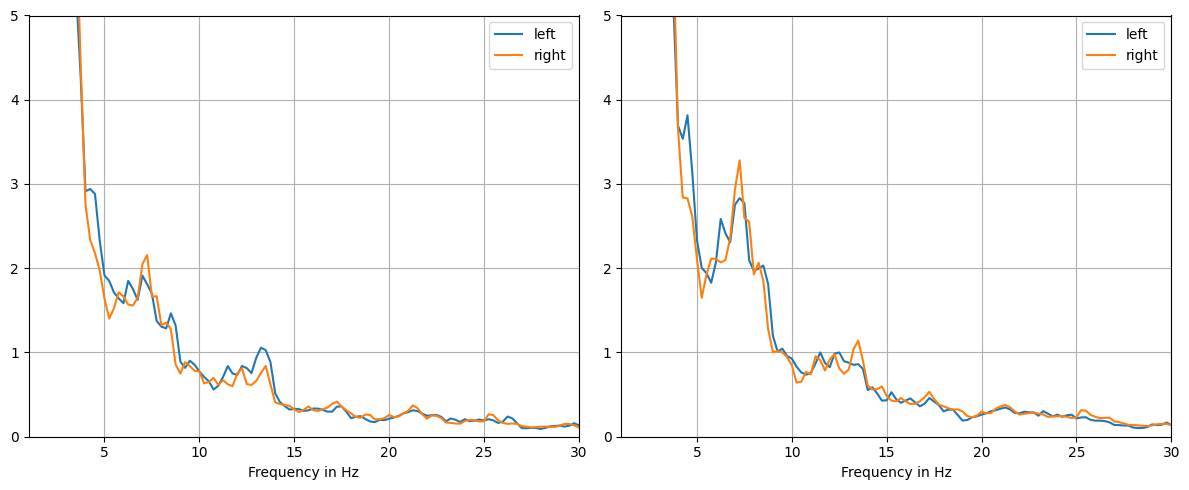

In [7]:
plot_psd({cl1:psd_l,cl2:psd_r},freqs,[channelNames.index(ch) for ch in ["C3","C4"]],5)


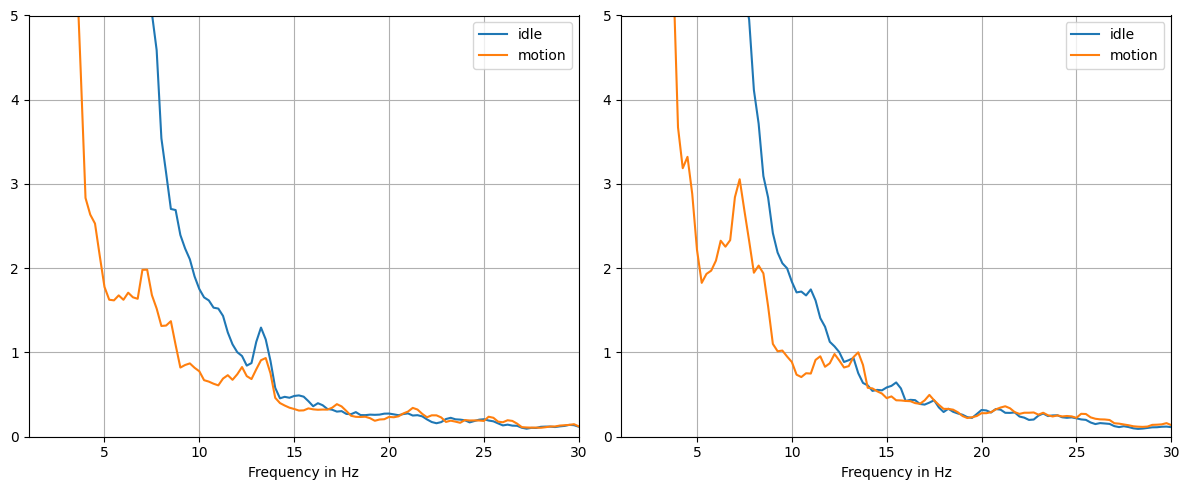

In [8]:
plot_psd({cl1:psd_idle,cl2:psd_motion},freqs_idle,[channelNames.index(ch) for ch in ["C3","C4"]],5,["idle", "motion"])


In [9]:
trials_filt = getFilteredTrials(trials,trialWindow,nChannels,sRate,classLabels=classLabels)
idleStateTrials_filt = getFilteredTrials(idleStateTrials,trialWindow, nChannels, sRate, classLabels=classLabels)


In [10]:
psd_l_filt,freqs_filt = psd(trials_filt[cl1],trialWindow, nChannels, sRate)
psd_r_filt,freqs_filt = psd(trials_filt[cl2], trialWindow, nChannels, sRate)


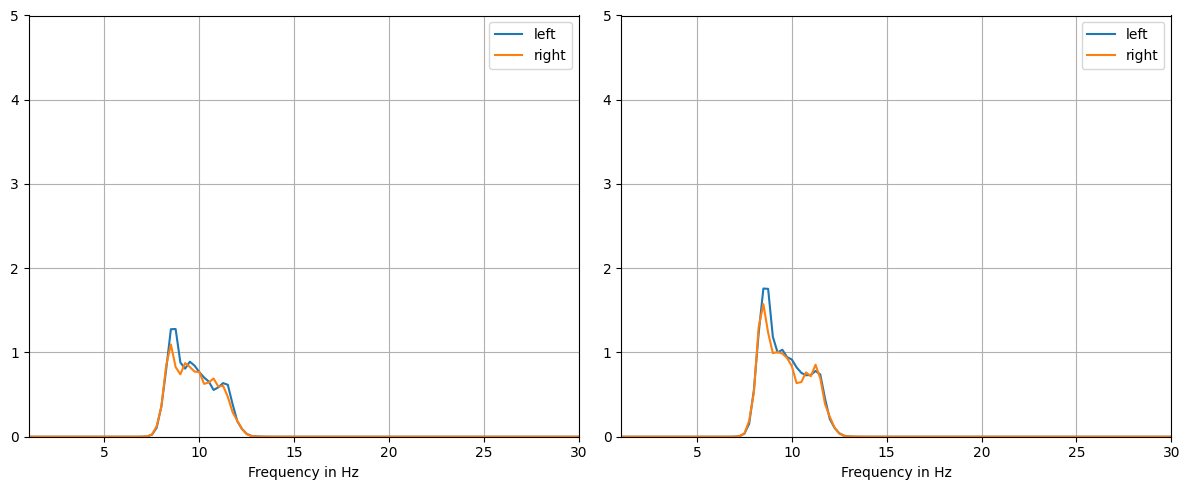

In [11]:
plot_psd({cl1:psd_l_filt,cl2:psd_r_filt},freqs_filt,[channelNames.index(ch) for ch in ["C3","C4"]],5)


In [12]:
psd_l_filt_idle,freqs_filt_idle = psd(np.concatenate([idleStateTrials_filt[cl1],idleStateTrials_filt[cl2]], axis=1),trialWindow, nChannels, sRate)
psd_r_filt_motion,freqs_filt_motion = psd(np.concatenate([trials_filt[cl1],trials_filt[cl2]], axis=1), trialWindow, nChannels, sRate)


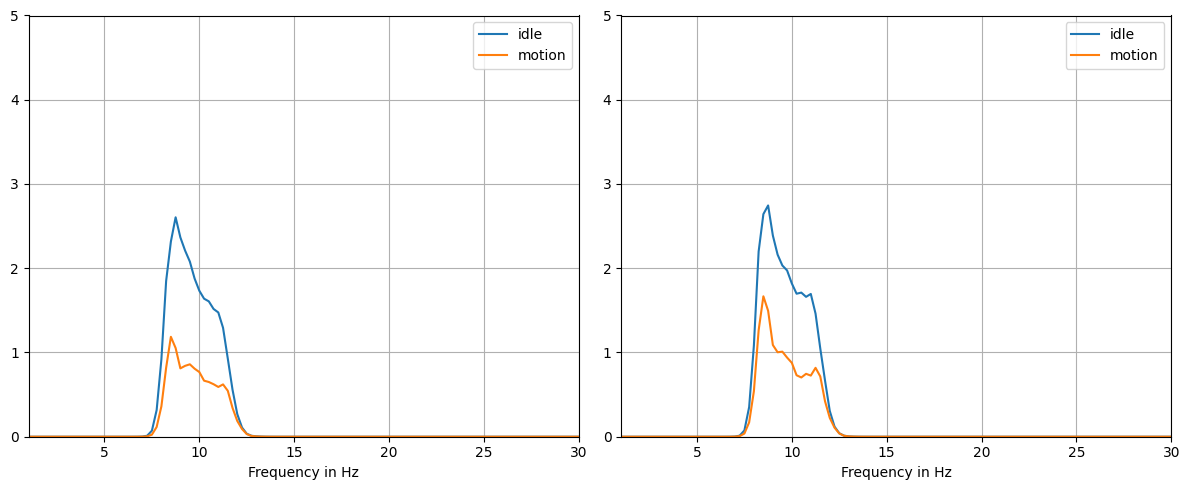

In [13]:
plot_psd({cl1:psd_l_filt_idle,cl2:psd_r_filt_motion},freqs_filt_idle,[channelNames.index(ch) for ch in ["C3","C4"]],5,["idle","motion"])


In [14]:
trials_logvar = {cl1:logvar(trials_filt[cl1]),
                 cl2:logvar(trials_filt[cl2])
                 }

idleMotionStateTrials_logvar = {cl1:logvar(np.concatenate([idleStateTrials_filt[cl1],idleStateTrials_filt[cl2]], axis=1)),
                          cl2:logvar(np.concatenate([trials_filt[cl1],trials_filt[cl2]], axis=1))}


### Log-var for motor imagery class 1 vs class 2

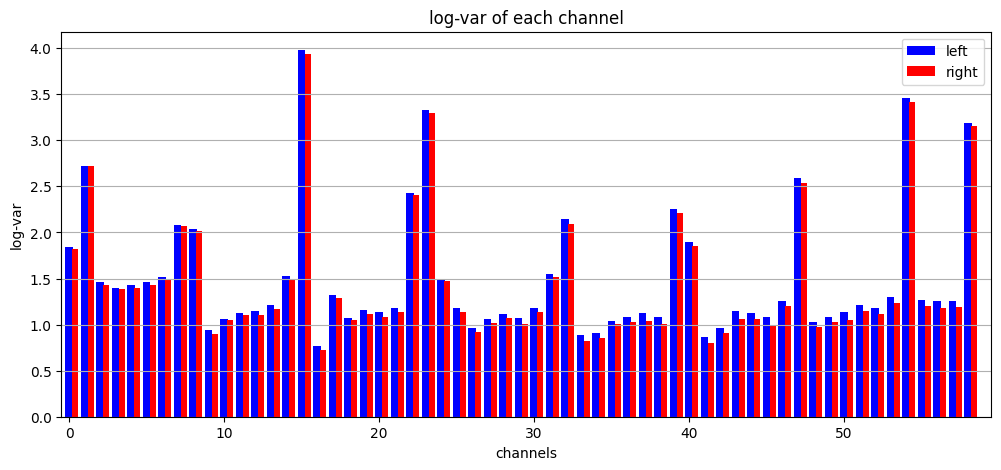

In [15]:
plot_logvar(trials_logvar,nChannels, classLabels)


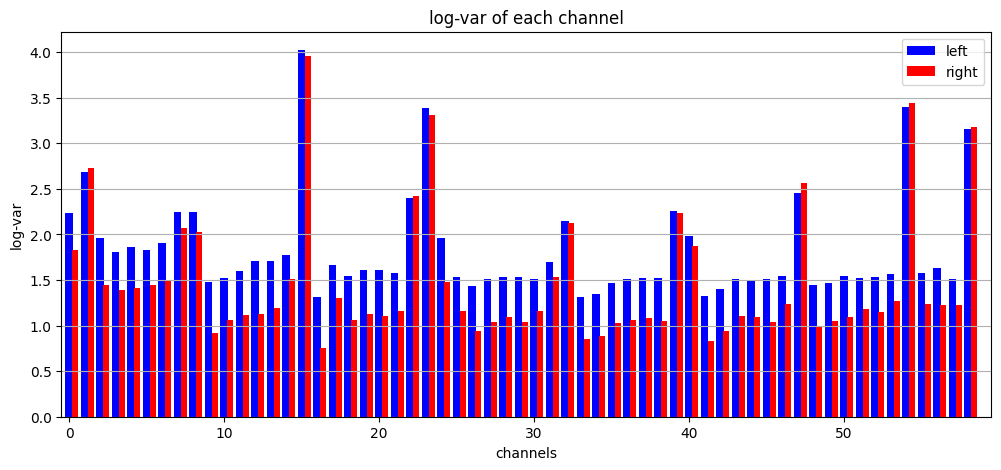

In [16]:
plot_logvar(idleMotionStateTrials_logvar,nChannels, classLabels)


In [17]:
W = csp(trials_filt[cl2],trials_filt[cl1])

W_idleState = csp(np.concatenate([trials_filt[cl1],trials_filt[cl2]], axis=1),np.concatenate([idleStateTrials_filt[cl1],idleStateTrials_filt[cl2]], axis=1) )

trials_csp = {
    cl1 : apply_mix(W,trials_filt[cl1], trialWindow, nChannels),
    cl2 : apply_mix(W,trials_filt[cl2], trialWindow, nChannels)
}

idleStateTrials_csp = {
    cl1 : apply_mix(W_idleState,np.concatenate([idleStateTrials_filt[cl1],idleStateTrials_filt[cl2]], axis=1), trialWindow, nChannels),
    cl2 : apply_mix(W_idleState,np.concatenate([trials_filt[cl1],trials_filt[cl2]], axis=1), trialWindow, nChannels)
}

trials_logvar = {
    cl1: logvar(trials_csp[cl1]),
    cl2:logvar(trials_csp[cl2])
}

idleStateTrials_logvar = {
    cl1: logvar(idleStateTrials_csp[cl1]),
    cl2:logvar(idleStateTrials_csp[cl2])
}


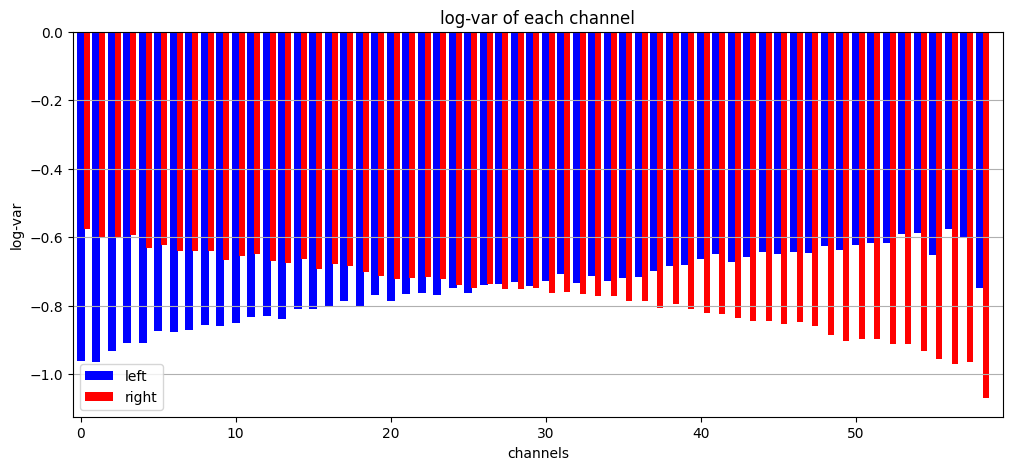

In [18]:
plot_logvar(trials_logvar,nChannels, classLabels)


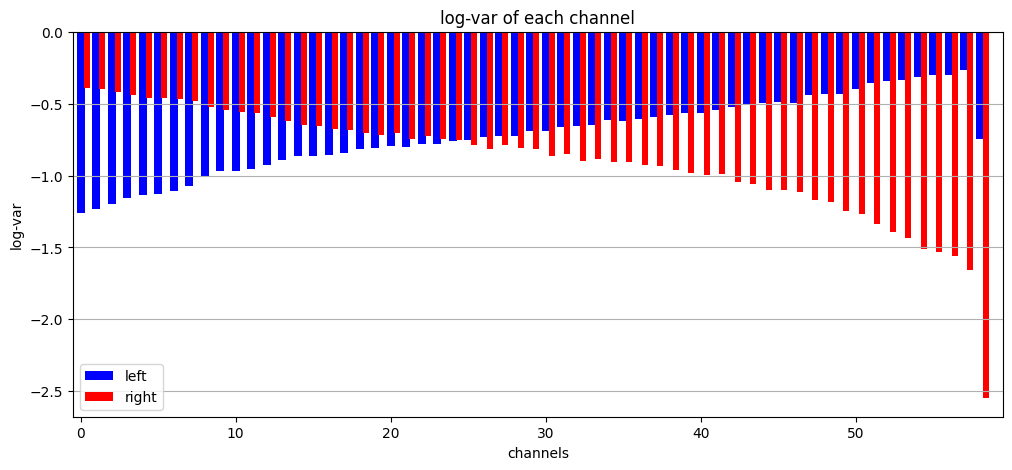

In [19]:
plot_logvar(idleStateTrials_logvar,nChannels, classLabels)


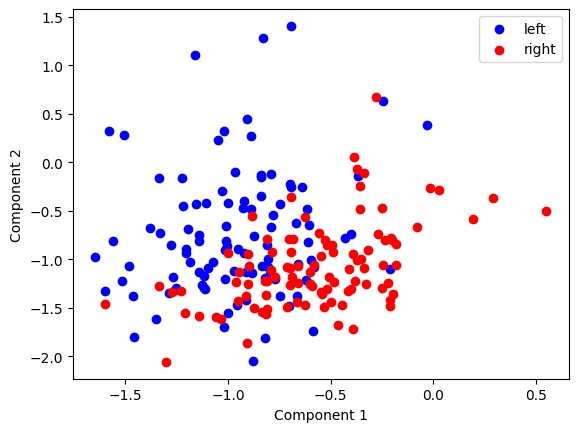

In [20]:
scatter(trials_logvar[cl1],trials_logvar[cl2],["left","right"],[0,-1])


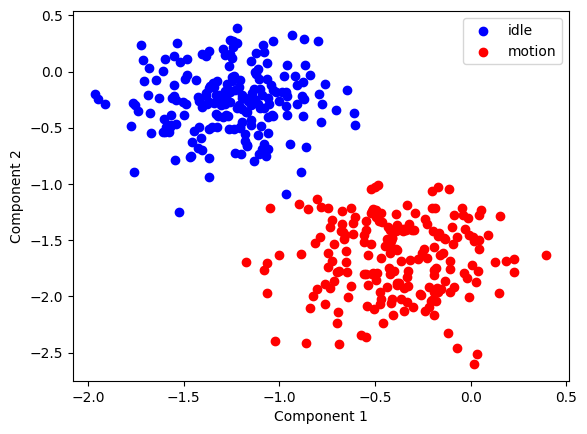

In [21]:
scatter(idleStateTrials_logvar[cl1],idleStateTrials_logvar[cl2],["idle","motion"],[0,-2])


In [23]:
data_D_df_train, _, _ = featureExtraction(data,0.7,[0,-1], [0,-2])


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [32]:
import pingouin as pg
pg.multivariate_normality(data_D_df_train["None"].iloc[:,:2], alpha=.05)


HZResults(hz=1.529598764489496, pval=0.0018523261460492504, normal=False)

In [27]:
data_D_df_train_idle, _, _ = featureExtraction(data,0.7,[0,-1], [0,-2], ExtractionType="idle_motionIntent")


In [33]:
pg.multivariate_normality(data_D_df_train_idle.iloc[:,:2], alpha=.05)


HZResults(hz=7.700687343400352, pval=6.559248335142853e-16, normal=False)